Submission Deadline: __November 20, 2023; 11:59 PM__

A penalty will be applied for late submission. Please refer to the course policy for more detail.  

## Instructions

Please read the instructions carefully before you start working on the homework.

- Please follow instructions and printed out the results as required. Keep the printed results and your implementation for grading purpose.
    - The TAs will not run your code for grading purpose unless it is necessary. That means, you may lose some points if the printed results are not in the submitted file.
- Submission should be via Canvas.
    - If you use Google Colab for running the code, please download the file and submit it via Canvas once it's done.
    - Submission via a Google Colab link will be considered as an invalid submission.
- Please double check the submitted file once you upload it to Canvas.
    - Students should be responsible for checking whether they submit the right files.
    - Re-submission is not allowed once the deadline is passed.

Also, if you missed the class lectures, please study the course materials first before working on the homework. It may save you some time.

# Homework 03 Language Modeling

In [ ]:
from os import chdir as cd

!ls
cd('NLP')
!pwd

Copy_of_HW_03.ipynb
Copy_of_HW_03_overfitted.ipynb
embedding_dim100hidden_size100num_layers2lr0.0001epochs1000
embedding_dim100hidden_size100num_layers2lr0.001
embedding_dim200hidden_size100num_layers2lr0.0001epochs50
embedding_dim250hidden_size512num_layers2lr0.001epochs100shuffled
wiki
wiki.zip


FileNotFoundError: [Errno 2] No such file or directory: 'NLP'

In [ ]:
! pip install livelossplot --quiet
! pip install tokenizers
! pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from typing import List, Tuple, Callable
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.util import ngrams
from nltk.lm import MLE
from nltk.tokenize import word_tokenize
import string as string
from nltk.util import ngrams
import numpy as np

import pickle

# Task: Language Modeling

Language modeling is a task in natural language processing where the goal is to predict the next word in a sequence of words. Given a sequence of words as input, the model predicts the probability distribution over the vocabulary for the next word. The output is a label representing the most likely next word.

For instance, if the input sequence is "the quick brown fox", the model will predict the probability distribution over the vocabulary for the next word, which could be "jumped", "ran", or any other word in the language.

In this assignment, we will perform language modeling using the [WikiText dataset](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/), which contains a large collection of text from Wikipedia articles. The task involves training models to generate coherent and contextually appropriate text, making it a fundamental problem in natural language processing.


# 1: N-Gram Language Modeling:  

In the context of n-grams, language modeling involes estimating the likelihood of a sequence of words/tokens based on the history of preceding words.


The goal of this portion of the assignment is to implement n-gram language models for values of $n \in [ 2, 4, 8]$, generate sample text, and calculate the perplexity of each n-gram model on the train set.

In [ ]:
# Download the data
!rm -rf wiki wiki.zip
import urllib.request
url = "https://yangfengji.net/uva-nlp-grad/data/wiki.zip"
filename, headers = urllib.request.urlretrieve(url, filename="wiki.zip")
!unzip wiki.zip
print("Done")

Archive:  wiki.zip
   creating: wiki/
  inflating: wiki/dev-wiki.txt       
  inflating: wiki/test-wiki.txt      
  inflating: wiki/trn-wiki.txt       
Done


## 1.1 Data Preprocessing : (2 points)

###### Complete the following code block to create the tokenizer necessary for the proceeeding experiments

- Create the train tokenizer with the following properties
    - Add a special **\<unk\>** token to replace any OOV tokens
    - Replace numeric tokens with the **\<num\>** token
    - Remove punctuation and symbols
    - Ensure the tokenizer prepends a **\<bos\>** and appends an **\<eos\>** token to every sequence
    
- Train the tokenizer on the train set of Wiki-Text

Please

- Print the vocabulary size of the tokenizer, using a necessary description of the printed result
- **N.B.** You may want to make use of the [huggingface tokenizer docs.](https://huggingface.co/docs/tokenizers/components)

In [ ]:
import tokenizers
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers import Tokenizer, Regex, normalizers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.processors import TemplateProcessing

from tokenizers.pre_tokenizers import Whitespace, Digits

In [ ]:
# define the tokenizer with the help of the huggingface docs:
# https://huggingface.co/docs/tokenizers/index
def train_tokenizer(fname: str) -> tokenizers.Tokenizer:
    """
    Args:
        fname: the name of the wiki.txt file

    Returns: Huggingface Tokenizer
    """
    PAD_TOKEN = '<pad>'
    UNK_TOKEN = '<unk>'
    NUM_TOKEN = '<num>'
    START_TOKEN= '<bos>'
    END_TOKEN= '<eos>'
    tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
    # =============================
    # TODO:

    tokenizer.add_special_tokens([PAD_TOKEN,
                                  UNK_TOKEN,
                                  NUM_TOKEN,
                                  START_TOKEN,
                                  END_TOKEN])

    tokenizer.pre_tokenizer = WhitespaceSplit()

    tokenizer.normalizer = normalizers.Sequence([normalizers.Lowercase(),
                                       normalizers.Replace(Regex('[^\w\s]+'), ""),
                                       normalizers.Replace(Regex('\d+'), NUM_TOKEN)
                                      ])


    tokenizer.post_processor = TemplateProcessing(
        single= START_TOKEN + " $0 " + END_TOKEN,
        pair=START_TOKEN + " $A " + END_TOKEN + " $B:1 " + END_TOKEN + ":1",
        special_tokens=[(START_TOKEN, tokenizer.token_to_id(START_TOKEN)), (END_TOKEN, tokenizer.token_to_id(END_TOKEN))],
    )

    trainer = WordLevelTrainer(special_tokens=[PAD_TOKEN,
                                            UNK_TOKEN,
                                            NUM_TOKEN,
                                            START_TOKEN,
                                            END_TOKEN])

    tokenizer.train([fname], trainer)

    return tokenizer


In [ ]:
# =============================
# TODO: Train the tokenizer
trained_tokenizer = train_tokenizer("wiki/trn-wiki.txt")

In [ ]:
# =============================
# TODO: Print the Vocab size
trained_tokenizer.get_vocab_size()

27419

In [ ]:
def sanity_check(tokenizer: tokenizers.Tokenizer,
                sample_text: str):
    """
    Args:
    """
    try:
        tokens = tokenizer.encode(sample_text).tokens
        assert tokens[0] == '<bos>'
        assert tokens[-1] == '<eos>'
        assert len(tokens) == len(sample_text.split(' ')) + 2
        assert all(token.islower() for token in tokens)
        print('Sanity Check Passed')
        print(tokens)
    except AssertionError as e:
        print('Tokenizer failed sanity check')
        print(tokens)
    return

In [ ]:
sample_text='The quick brown fox jumped over the lazy dog'
sanity_check(trained_tokenizer, sample_text)

Sanity Check Passed
['<bos>', 'the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '<eos>']


# 1.2 Train the N-Gram Model : (2 pts)  

If the tokenizer passed the basic sanity check then proceed.

**TODO**
 - Train n-gram models for $n \in \{ 2, 4, 6, 8, 10\}$
 - Complete the get_ngrams function below, to return a list of all the n-grams
     - Each entry in this list represents all the n-grams for a given sentence
 - For each n-gram model, fit the model to it respective set of n-grams

In [ ]:
def get_ngrams(fname: str,
                  tokenizer: tokenizers.Tokenizer,
                    n: int) -> List[str]:
    """
    Args:
        fname:

    Returns:
        all_ngrams: list of all n-grams
        for all sentences
    """
    all_ngrams = []
    # =============================
    # TODO: implement the function
    #       to get the ngrams for
    #       all the sentences

    all_ngrams = []
    with open(fname, "r") as file:
      # lets collect by paragraph
      paragraph = ""

      for line in file:
        if line.strip() == "":
          if paragraph:
            tokenized_paragraph = tokenizer.encode(paragraph).tokens

            ngram_tuples = list(ngrams(tokenized_paragraph, n))
            if len(ngram_tuples) == 0:
              continue

            all_ngrams.append(ngram_tuples)

            paragraph = ""
        else:
          paragraph += " " + line.strip()

      if paragraph:
        tokenized_paragraph = tokenizer.encode(paragraph).tokens
        ngram_tuples = list(ngrams(tokenized_paragraph, n))
        if len(ngram_tuples) != 0:
          all_ngrams.append(ngram_tuples)


    return all_ngrams

In [ ]:
created_ngrams=get_ngrams('wiki/trn-wiki.txt', trained_tokenizer, 2)
vocabulary = list(trained_tokenizer.get_vocab().keys())
print(vocabulary[0])
print(created_ngrams[1])

print(type(vocabulary[0]))
print(type(created_ngrams[0]))

retinue
[('<bos>', 'senjō'), ('senjō', 'no'), ('no', 'valkyria'), ('valkyria', '<num>'), ('<num>', '<unk>'), ('<unk>', 'chronicles'), ('chronicles', 'japanese'), ('japanese', '戦場のヴァルキュリア<num>'), ('戦場のヴァルキュリア<num>', 'lit'), ('lit', 'valkyria'), ('valkyria', 'of'), ('of', 'the'), ('the', 'battlefield'), ('battlefield', '<num>'), ('<num>', 'commonly'), ('commonly', 'referred'), ('referred', 'to'), ('to', 'as'), ('as', 'valkyria'), ('valkyria', 'chronicles'), ('chronicles', 'iii'), ('iii', 'outside'), ('outside', 'japan'), ('japan', 'is'), ('is', 'a'), ('a', 'tactical'), ('tactical', 'role'), ('role', 'playing'), ('playing', 'video'), ('video', 'game'), ('game', 'developed'), ('developed', 'by'), ('by', 'sega'), ('sega', 'and'), ('and', 'mediavision'), ('mediavision', 'for'), ('for', 'the'), ('the', 'playstation'), ('playstation', 'portable'), ('portable', 'released'), ('released', 'in'), ('in', 'january'), ('january', '<num>'), ('<num>', 'in'), ('in', 'japan'), ('japan', 'it'), ('it', 'is

In [ ]:
# =============================
# TODO: Train the n-gram models

# I think for this we use the nltk.lm MLE model.
# lets also try generating some text with the trained model


model = MLE(2)
model.fit(get_ngrams('wiki/trn-wiki.txt', trained_tokenizer, 2),
          trained_tokenizer.get_vocab().keys())
model.generate(num_words=10, text_seed=['referred', 'to'])

['the',
 'catholic',
 'with',
 '<unk>',
 'latex',
 'and',
 'ambitious',
 'attempt',
 'to',
 'alaska']

# 1.3  Compute N-Gram Perplexity  (2 pts)

### Perplexity is a measure of how well a given distribution predicts a sample. In the context of language modeling, the perplexity is based on how well the model predicts a given corpus. The formula for computing perplexity-per-word of an n-gram model is given by:  

$$\text{PPW} = 2^{\frac{1}{W} \sum_{i=1}^{N} H(p, q)}$$

where: $$ H(p, q) = -\sum_{x} p(x) log(q()) $$

$H(p,q)$ may be interpreted as the cross-entropy between the distributions. However, for the n-gram model, nltk provides a [function which computes the perplexity](https://www.nltk.org/api/nltk.lm.api.html#nltk.lm.api.LanguageModel.perplexity).

**TODO**
- $\text{For n} \in \{2, 4, 6, 8 ,1 0\}$, compute the perplexity of each n-gram model on the train set
- You will need the $\texttt{get_ngrams}$ function in your $\texttt{ngram_perplexity}$ function

In [ ]:
from nltk.lm import vocabulary
from itertools import chain

def ngram_perplexity(fname: str,
                     n:int,
                    tokenizer: tokenizers.Tokenizer,
                    ) -> float:
    """
    Arg:

    Returns:
    """
    # =============================
    # TODO: Implement the function
    #       to compute perplexity for a given
    #       n-gram model

    ngrams=get_ngrams('wiki/trn-wiki.txt', tokenizer, n)
    vocabulary = list(tokenizer.get_vocab().keys())

    model = MLE(n)
    model.fit(ngrams, vocabulary)

    test_ngrams = get_ngrams(fname, tokenizer, n)

    flattend=list(chain.from_iterable(test_ngrams))

    return model.perplexity(flattend)

In [ ]:
#
# =============================
# TODO: compute the perplexity for varying values of n
perplexity_value=ngram_perplexity('wiki/trn-wiki.txt', 4, trained_tokenizer)
print(perplexity_value)

1.7656531261909916


# 1.4 Plot N-gram Size vs Perplexity : (2 pts)  

**TODO**:
 - $\text{For n} \in \{2, 4, 6, 8 ,1 0\}$ plot the N-Gram size vs Perplexity for each of the n-gram models

In [ ]:
# =============================
# TODO: create the plots

ngram_lengths = [2, 4, 6, 8, 10]
perplexities = []

for n in ngram_lengths:
  perplexities.append(ngram_perplexity('wiki/trn-wiki.txt', n, trained_tokenizer))


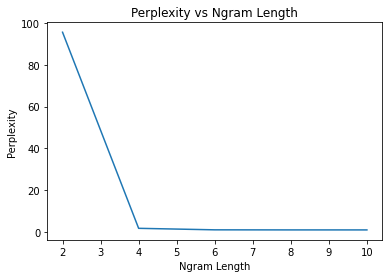

In [ ]:
plt.plot(ngram_lengths, perplexities)
plt.xlabel('Ngram Length')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Ngram Length')
plt.show()

# 1.4 Interpretation of N-gram Size vs Perplexity : (1 pt)  

**TODO**: In the Markdown cell below, explain the effect you observe, why do you think this is the case?

This [Stanford textbook](https://web.stanford.edu/~jurafsky/slp3/3.pdf) has a really good explanation of Perplexity that made a lot of sense to me.

Perplexity is the **weighted average branching factor** of a language. So its the number of next possible words that can follow a given word. So as we increase the number of n-grams within our model, we are gauranteed to see a decrease in perplexity. Because in our larger-gram models, we have "more strict" sequences where a word is seen.

Because of the context that higher-gram models offer, models can apply this context into their computations of selecting the next word. This can better inform the probabilities of their next words, concentrating the probabilities among fewer words and decreasing perplexity.

# Simple RNN LM

# 2.1 Train a Recurrent Neural Network on the Train Set of Wiki-Text
## Preprocessing (1pt)

**TODO**
- use the tokenizer to preprocess the text and create the necessary dataloaders
- enable padding for the tokenizer

In [ ]:
import torch
import torch.nn as nn
from livelossplot import PlotLosses
import math

plotlosses = PlotLosses()

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
# device = torch.device("cpu")

CUDA is available. Using GPU.


In [ ]:
# =============================
# TODO: enable padding for tokenizer
trained_tokenizer.enable_padding(
    pad_id=trained_tokenizer.token_to_id("<pad>"),
    pad_token="<pad>")

In [ ]:
#https://huggingface.co/docs/datasets/loading_datasets.html
from datasets import load_dataset
import torch.utils
dataset = load_dataset('text', data_files={'train': 'wiki/trn-wiki.txt', 'dev': 'wiki/dev-wiki.txt'})

## 2.1.1 Dataloaders and Padding
**TODO**
- Create the train and dev_dataloaders

In [ ]:

def collate(examples: List[str]) -> torch.Tensor:
    """
    Args:
        examples
    """
    return torch.LongTensor([ex.ids for ex in trained_tokenizer.encode_batch(examples)])

# =============================
# TODO: define dataloaders


trn_dataloader = torch.utils.data.DataLoader(dataset['train']['text'],
                                             batch_size=32,
                                             shuffle=True,
                                             collate_fn=collate)
dev_dataloader = torch.utils.data.DataLoader(dataset['dev']['text'],
                                             batch_size=32,
                                             shuffle=False,
                                             collate_fn=collate)

## 2.1.2 RNN-Language Model Forward Pass
## Define the Language Model (2 pts)
**TODO**
- Implement the forward pass of the RNN

In [ ]:
#TODO: Implement the Forward Pass
class TokenRNN(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embedding_dim: int,
                 hidden_size: int,
                 output_size: int,
                 num_layers:int=1):
        """
        Args:

        """
        super(TokenRNN, self).__init__()
        self.vocab_size_input = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: input sequence of tokens

        Returns:
            output: probability distribution over the vocab
                    for the next token at each time step
        """
        # =============================
        # TODO:

#         print("Input max index:", x.max().item())
#         print("Input min index:", x.min().item())
#         assert x.max().item() < self.vocab_size_input, "Index exceeds vocabulary size"
#         assert x.min().item() >= 0, "Index less than 0"


        x = self.embedding(x)

        x, _ = self.rnn(x)

        # here:
        # x = x.reshape(-1, x.shape[2])

        x = self.out(x)

        return x



In [ ]:
# =============================
# TODO: Declare instance of TokenRNN
# Define Hyperparameters

inst = TokenRNN(vocab_size=trained_tokenizer.get_vocab_size() + 1,
                embedding_dim=250,
                hidden_size=512,
                output_size=trained_tokenizer.get_vocab_size() + 1,
                num_layers=2)

## 2.1.3 Train the Model (2 pt)

In [ ]:
# TODO:
def train(model: nn.Module,
         dataloader: torch.utils.data.dataloader,
         criterion: nn.modules.loss,
         optimizer: torch.optim,
         device: torch.device,
         num_epochs: int) -> float:
    """
    Args:
        model:
        dataloader:
        criterion:
        optimizer:
        device:
        num_epochs:

    Return: final perplexity value after training

    """

    # for RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR
    # torch.backends.cudnn.enabled = False

    for epoch in range(1, num_epochs+1):
        logs = {}
        model.train()
        model = model.to(device)
        total_loss = 0

        for batch in dataloader:
          # print("bob")
          # =============================
          # TODO: Define training function

          batch = batch.to(device)
          inputs = batch[:, :-1]  # All except the last token
          targets = batch[:, 1:]  # All except the first token

          inputs = inputs.to(device)
          targets = targets.to(device)

          optimizer.zero_grad()  # Zero the gradients

          # Forward pass
          outputs = model(inputs)

          # print(outputs.shape)
          # print(targets.shape)

          # Reshape outputs and targets for the criterion
          # Outputs are likely of shape [batch_size, sequence_length, vocab_size]
          # Targets are of shape [batch_size, sequence_length]
          # Criterion expects inputs of shape [batch_size * sequence_length, vocab_size]
          # and targets of shape [batch_size * sequence_length]
          outputs = outputs.reshape(-1, outputs.shape[-1])
          targets = targets.reshape(-1)

          # print(outputs.shape)
          # print(targets.shape)

          # Compute loss
          loss = criterion(outputs, targets)
          # print(loss)
          total_loss += loss.detach().item()

          # Backward pass and optimize
          loss.backward()
          optimizer.step()

        logs['loss'] = total_loss/len(dataloader)
        logs['perplexity'] = math.exp(logs['loss'])
        plotlosses.update(logs)
        plotlosses.send()
    average_loss = total_loss / len(dataloader)
    final_perp = math.exp(average_loss)
    return final_perp

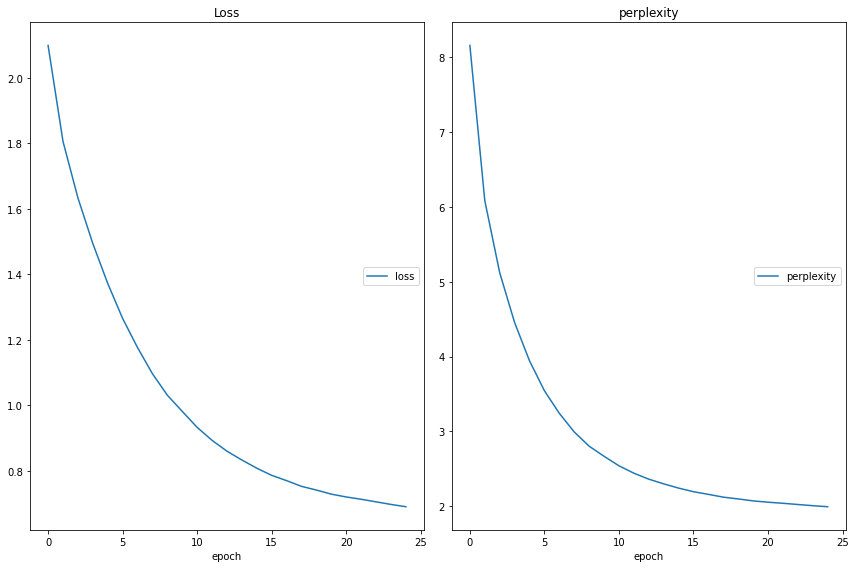

Loss
	loss             	 (min:    0.690, max:    2.099, cur:    0.690)
perplexity
	perplexity       	 (min:    1.994, max:    8.159, cur:    1.994)


In [ ]:
# =============================
# TODO: train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inst.parameters(), lr=0.001)

num_epochs = 25

# inst.to(device)
model_train_perp = train(inst,
                         trn_dataloader,
                         criterion,
                         optimizer,
                         device,
                         num_epochs)

In [ ]:
# =============================
# TODO: Report the final train perplexity
print(model_train_perp)

1.9942436329898596


In [ ]:
import pickle

filename = "final_model_embedding_dim_" + str(250) + "_hidden_size_" + str(512) + "_num_layers_" + str(2) + "_lr_0_001_" + "epochs_" + str(25) + "_shuffled"
pickle.dump(inst, open(filename, 'wb'))

## 2.2  Evaluate Perplexity on the Validation Set (2 pts)
**TODO**
- Report the perplexity of the RNN on the validation set

In [ ]:
# =============================
# TODO: Report the perplexity on the Validation Set

def compute_validation_perplexity(model: nn.Module,
         dataloader: torch.utils.data.dataloader,
         criterion: nn.modules.loss,
         device: torch.device) -> float:
    """
    Args:
        model:
        dataloader:
        criterion:
        device:

    Return: final perplexity value after validation

    """
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            inputs = batch[:, :-1]  # All except the last token
            targets = batch[:, 1:]  # All except the first token

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Reshape outputs and targets for the criterion
            # Outputs are likely of shape [batch_size, sequence_length, vocab_size]
            # Targets are of shape [batch_size, sequence_length]
            # Criterion expects inputs of shape [batch_size * sequence_length, vocab_size]
            # and targets of shape [batch_size * sequence_length]
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = targets.reshape(-1)

            # Compute loss
            loss = criterion(outputs, targets)
            # print(loss)
            total_loss += loss.detach().item()

    average_loss = total_loss / len(dataloader)
    final_perp = math.exp(average_loss)
    return final_perp


In [ ]:
validation_perp = compute_validation_perplexity(inst, dev_dataloader, criterion, device)
print(validation_perp)

15.049178280946014


## Generating Sequences With the RNN (Extra: 1 pt)

Temperature scaling allows us to adjust the level of stochasticity associated with the model predictions. We can introduce a temperature parameter to the softmax probability of a given token, via:

$$ P(y_i) = \frac{e^{z_i / T}}{\sum_j e^{z_j / T}}$$

Where:
 - $P(y_{i})$ is the probability of class i.
 - $z_{i}$ is the probability of class i.
 - T is the temperature parameter

**TODO**

 - For temperature values in the range 1..10 (inclusive), seed the language model with a '\<bos\>' token and produce a sequence until the appropriate stopping condition occurs.

- Plot the Temperature Value vs the Length of the Sequence Produced

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# generate based on using the collate function

import torch.nn.functional as F

def generate(model: nn.Module,
            temperature:int,
            tokenizer: tokenizers.Tokenizer,
            device) -> str:
    """
        Args:
            model:
            temperature: scale the logits
    """
    sequence = []
    # =============================
    # TODO: Define the temperature-scaled
    #       generation function

    model.eval()
    sequence.append('<bos>')

    with torch.no_grad():
        while True:
            logits = model(collate(sequence).to(device))
            scaled_logits = logits[0, -1, :] / temperature

            probabilities = F.softmax(scaled_logits, dim=-1)
            probabilities = probabilities.squeeze(0)

            next_token_id = torch.multinomial(probabilities, num_samples=1)
            next_token = tokenizer.decode([next_token_id[0].item()])

            sequence.append(next_token)

            if next_token == '<eos>' or next_token == '<pad>' or len(sequence) > 3000:
                break
    return ' '.join(sequence)

In [ ]:
# =============================
# TODO: Generate sequences of varying temperature (T) values
generated_sequences = []
for T in range(1, 11):
    torch.cuda.empty_cache()
    print("Generating sequence with temperature: {}".format(T))
    generated_sequences.append(
        generate(loaded_model, T, trained_tokenizer, device)
        )

Generating sequence with temperature: 1


/home/ssb3vk/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Generating sequence with temperature: 2
Generating sequence with temperature: 3
Generating sequence with temperature: 4
Generating sequence with temperature: 5
Generating sequence with temperature: 6
Generating sequence with temperature: 7
Generating sequence with temperature: 8
Generating sequence with temperature: 9
Generating sequence with temperature: 10


#  Plot Temperature (T) vs Sequence Length (L) : what do you notice and why?

Text(0, 0.5, 'Sequence Length (L)')

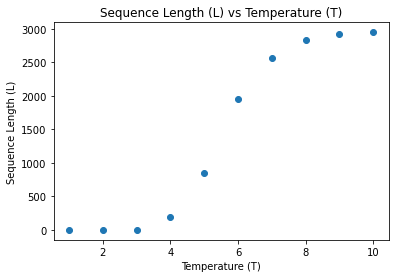

In [ ]:
# =============================
# TODO: Plot T vs L

T = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]



plt.scatter(T, [len(seq.split()) for seq in generated_sequences])

plt.title("Sequence Length (L) vs Temperature (T)")
plt.xlabel("Temperature (T)")
plt.ylabel("Sequence Length (L)")

Here I notice a sigmoid curve in terms of sequence length vs temperature. I find this super interesting. From a "simple" view, we know that by increasing temperature, we flatten out the probability distribution. Words with high likelihood become less likely to be selected and words with low likelihood become more likely to be selected (relatively).

So, for higher temperatures we are more likely to have long, meandering sequences. These sequences are more likely to be diverse and longer as the "<eos>" token is less likely to be selected.

For lower temperatures, we enunciate tokens with larger probability more, leading to quickly-terminating sequences. As the model is more likely to select the common "<eos>" token.

While this all tracks, why is the curve a near perfect sigmoid. Surely there must be something else occuring? I believe that this shape is due to the how the P(y_i) is formulated. Because we are modifying the natural power of the probability we generate the sigmoid shape. Let me demonstrate via the following Markov random walker.

In this example we have only have two classes, the terminating class and the continuing class. We also use multiple different functions including:
*   e^i
*   i^2
*   i^(1/2)
*   1/i
*   i

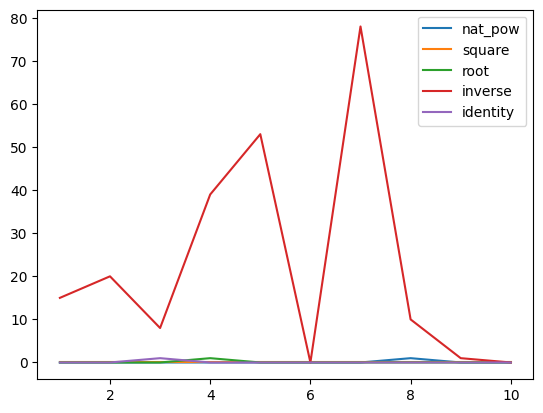

In [48]:
import math
import random
import matplotlib.pyplot as plt

probability_term = 19
probability_cont = 1

def nat_pow(i):
  return math.exp(i)

def square(i):
  return i**2

def root(i):
  return i**(1/2)

def inverse(i):
  return 1 / i

def identity(i):
  return i

functions = [nat_pow, square, root, inverse, identity]
T = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i, f in enumerate(functions):
  term_length = []
  for temp in T:
    mod_prob_term = f(probability_term / temp) / (f(probability_term / temp) + f(probability_cont / temp))
    mod_prob_cont = f(probability_cont / temp) / (f(probability_term / temp) + f(probability_cont / temp))

    r = random.uniform(0, mod_prob_term + mod_prob_cont)
    iters = 0

    while r > mod_prob_term:
      r = random.uniform(0, mod_prob_term + mod_prob_cont)
      iters += 1

    term_length.append(iters)

  plt.plot(T, term_length, label=f.__name__)

plt.legend()
plt.show()


Clearly, this graph isn't exactly what I am looking for. But it may be indicative that there is more going on in the temperature/logits functoin than I have anticipated.

This problem ultimiately reduces down to how applying a scaling to the q-probabilities (transition probabilities) of a markov chain walker (where there is a terminating state on the chain) affects the length of the walk.

But, the text generation model is different. Text generation models don't simply make random decisions on which token to output, instead they take into consideration the prior history and **then** make a decision on the next token. This completely distinguishes them from markov walkers. If the model was a true markov walker (and ignored prior context) then the sequence length vs temperature graphs would look like they do above.

But instead, because it does consider the prior context of constructed sentences, it produces the sigmoid curve as shown.